# `016` Transformers

Requirements: 014 Attention and dropout, 015 Residual connections

Attention mechanisms were proposed as a way to make the RNN inputs contain information about other terms in the sequence. This way, every sequence element can be contextualized properly with the information from other tokens. However, an architecture called transformer proposed by [Vaswani et al., 2017](ttps://arxiv.org/pdf/2002.04745v1.pdf) took the world by surprise.

Basically, he removed the RNN layers and used just a bunch of linear layers, attention mechanisms, residual connections and normalization. Applied in the context of German to English translation, the architecture achieved better quality (BLEU score) than any previous model. Furthermore, applying it over general text corpuses created a level of generalization pretty impressive and scalable with model size.

In this notebook I will define a transformer block, build a model with many of them, and train it over the Spanish novels corpus also used for the Embeddings notebook.

In [1]:
from matplotlib import pyplot as plt
from re import sub
from time import time
import torch

device = torch.device('cuda' if torch.backends.cudnn.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: mps


In [2]:
tokens = ' !(),-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz¡¿ÁÉÍÑÓÚÜáéíñóúü'
t2i = {c: i for i, c in enumerate(tokens)}
i2t = {i: c for i, c in enumerate(tokens)}

with open('custom-data/spanish-novels.txt', encoding='utf-8') as fp:
	data = fp.read()

data = sub(r'\s*\n\s*', ' ', data)
data = [t2i[c] for c in data if c in tokens]
data = torch.tensor(data, dtype=torch.long).to(device)
print(f'dataset size: {data.shape[0]} (that\'s like {100 * data.shape[0] / 20000000000000:.6f}% of GPT-4\'s training data)')

dataset size: 19263904 (that's like 0.000096% of GPT-4's training data)


In [3]:
def get_batch(split='train', train_size=.8, size=64, context_size=256):
	limit = int(data.shape[0] * train_size) if split == 'train' else data.shape[0]
	starts = torch.randint(0, limit - context_size, (size,))
	x = torch.stack([data[s:s+context_size] for s in starts])
	y = torch.stack([data[s+1:s+context_size+1] for s in starts])
	return x, y

x, y = get_batch(size=4)
print(x.shape, y.shape)
print(''.join(i2t[j.item()] for j in x[0]))
print(''.join(i2t[j.item()] for j in y[0]))

torch.Size([4, 256]) torch.Size([4, 256])
ue, cuando los glaciares se derretían y se retiraban ligeramente, en el verano dejaban restos de arena y cascajo. Esa arena y ese cascajo, ¿podía ser que hubieran sido arrastrados por las laderas de la montaña y que el glaciar completara esa tarea al mover
e, cuando los glaciares se derretían y se retiraban ligeramente, en el verano dejaban restos de arena y cascajo. Esa arena y ese cascajo, ¿podía ser que hubieran sido arrastrados por las laderas de la montaña y que el glaciar completara esa tarea al movers


Now let's define the trasnformer block. This block can be understood like an individual step in the thinking process: first you pay attention to something specific (attention layer), and then you extract conclusions about it (linear layer).

To prevent vanishing/exploding gradients from happening, normalizations are added in between both. In the original transfomers paper batch normalization was used. However, batchnorm is annoying in that the elements in the batch have interdependencies when computing the average and standard deviation, so in practice approaches like LayerNorm or RMSNorm are used. RMSNorm stands for Root Mean Squared normalization, and it's as simple as squaring all the weights, adding them together, and dividng all weights by the root square of that number, so that the "vector" of weights becomes unitary (norm = 1).

Additionally, residual connections are added all over the model. This way, transformers can be thought as a main gradient highway that is the original value, and at each step we fork from that highway, do something, and merge back in.

In [4]:
class TransformerBlock(torch.nn.Module):
	def __init__(self, context_size=128, channels=256, num_heads=8, dropout=.1):
		super().__init__()
		self.attn = torch.nn.MultiheadAttention(channels, num_heads, dropout, batch_first=True)
		mask = torch.tril(torch.ones(context_size, context_size, device=device)) == 0
		self.register_buffer('causal_mask', mask)
		self.norm1 = torch.nn.LayerNorm(channels)
		self.ff = torch.nn.Sequential(
			torch.nn.Linear(channels, 4 * channels),
			torch.nn.GELU(),  # GELU works slightly better than ReLU for transformers
			torch.nn.Linear(4 * channels, channels)
		)
		self.dropout = torch.nn.Dropout(dropout)
		self.norm2 = torch.nn.LayerNorm(channels)

	def forward(self, x):
		x = self.norm1(x)
		x = x + self.attn(x, x, x, attn_mask=self.causal_mask)[0]
		x = self.norm2(x)
		x = x + self.ff(x)
		x = self.dropout(x)
		return x

Now let's build the language model out of it. We'll basically just embed all tokens, pass them through a bunch of transformer layers, and then use a linear layer to output the logits of weights.

In [5]:
class LanguageModel(torch.nn.Module):
	def __init__(self, vocab_size, context_size=128, hidden_size=512, num_blocks=8, num_heads=8, dropout=.1):
		super().__init__()
		self.tok_emb = torch.nn.Embedding(vocab_size, hidden_size)
		self.pos_emb = torch.nn.Embedding(context_size, hidden_size)
		self.register_buffer('pos', torch.arange(context_size, device=device))
		self.blocks = torch.nn.Sequential(*[
			TransformerBlock(context_size, hidden_size, num_heads, dropout)
			for _ in range(num_blocks)
		])
		self.out = torch.nn.Linear(hidden_size, vocab_size)

	def forward(self, x):
		x = self.tok_emb(x) + self.pos_emb(self.pos)
		x = self.blocks(x)
		x = self.out(x)
		return x

model = LanguageModel(len(tokens)).to(device)
print(f'Model has {sum(p.numel() for p in model.parameters())} parameters')

Model has 25375833 parameters


Instead of using a fixed learning rate, we will be using a learning rate scheduler. A scheduler modifies the learning rate over time. I usually have best results with OneCycleLR, as it starts with a low learning rate and gradually increases it during a warmup in order to find a good region of the loss landscape. Then it decreases it to find the minimum.

/Users/carlos/Library/Python/3.11/lib/python/site-packages/torch/optim/lr_scheduler.py:168: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


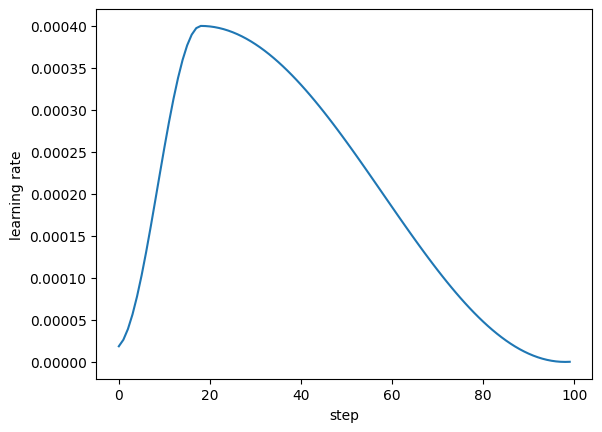

In [6]:
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=4e-4, total_steps=100, pct_start=.2)
X = []
for _ in range(100):
	scheduler.step()
	X.append(scheduler.get_last_lr()[0])
plt.plot(X)
plt.xlabel('step')
plt.ylabel('learning rate');

Let's now train our network to see how well it learns. One problem with these pretty deep neural networks with so many attention layers is that they need much lower learning rates, and hence many more training steps. This is one of the main problems that make training unfeasible in domestic computers in reasonable times anymore. For instance, training a GPT-2 level network requires about 16 hours in a cluster of 8 A100 GPUs as of 2024, which means spending around $200.

In [7]:
train_losses, test_losses, lrs = [], {}, []

def train(model, epochs=2000, batch_size=32, gradient_accumulation=32, context_size=128, max_lr=4e-4):
	model.train()
	optimizer = torch.optim.AdamW(model.parameters(), betas=(.9, .95))
	scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=epochs, pct_start=.2)
	start = time()
	loss = 0
	for e in range(epochs):
		optimizer.zero_grad()
		epoch_train_loss = 0
		for _ in range(gradient_accumulation):
			# compute loss
			x_batch, y_batch = get_batch(size=batch_size, context_size=context_size)
			logits = model(x_batch).view(-1, len(tokens))
			loss = torch.nn.functional.cross_entropy(logits.view(-1, len(tokens)), y_batch.view(-1))
			epoch_train_loss += loss.item()
			# update
			loss.backward()
		optimizer.step()
		scheduler.step()
		torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
		# stats
		train_losses.append(epoch_train_loss / gradient_accumulation)
		if e % (epochs // 10) == 0 or e == 10:
			remaining = (time() - start) * (epochs - e - 1) / (e + 1)
			remaining = f'{remaining//3600:02.0f}:{remaining%3600//60:02.0f}:{remaining%60:02.0f}'
			x_batch, y_batch = get_batch('test', size=batch_size, context_size=context_size)
			logits = model(x_batch).view(-1, len(tokens))
			test_loss = torch.nn.functional.cross_entropy(logits.view(-1, len(tokens)), y_batch.view(-1))
			test_losses[e] = test_loss.item()
			print(f'epoch {e:4d} | lr {scheduler.get_last_lr()[0]:.6f} | train loss {train_losses[-1]:6f} | test loss {test_loss:6f} | remaining {remaining}')

train(model)

epoch    0 | lr 0.000016 | train loss 4.674790 | test loss 4.510019 | remaining 04:54:41
epoch   10 | lr 0.000016 | train loss 3.495649 | test loss 3.422682 | remaining 04:45:21
epoch  200 | lr 0.000113 | train loss 2.344377 | test loss 2.325606 | remaining 05:31:27
epoch  400 | lr 0.000305 | train loss 1.985950 | test loss 1.968146 | remaining 04:16:06
epoch  600 | lr 0.000400 | train loss 1.700275 | test loss 1.711359 | remaining 03:45:42
epoch  800 | lr 0.000380 | train loss 1.509303 | test loss 1.470416 | remaining 03:05:51
epoch 1000 | lr 0.000324 | train loss 1.411085 | test loss 1.413461 | remaining 02:31:04
epoch 1200 | lr 0.000244 | train loss 1.344384 | test loss 1.411799 | remaining 01:58:47
epoch 1400 | lr 0.000155 | train loss 1.315488 | test loss 1.294693 | remaining 01:27:58
epoch 1600 | lr 0.000075 | train loss 1.288881 | test loss 1.338376 | remaining 00:58:03
epoch 1800 | lr 0.000019 | train loss 1.274802 | test loss 1.297086 | remaining 00:28:44


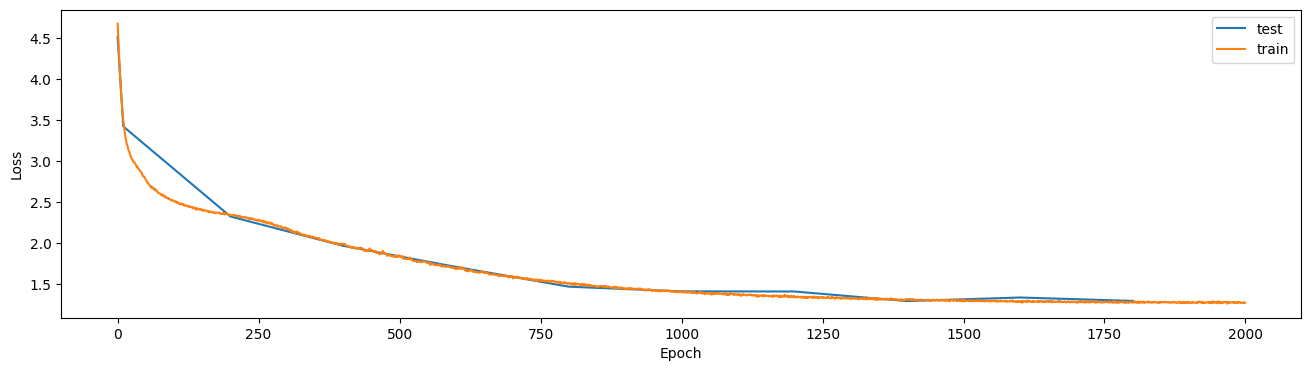

In [11]:
plt.figure(figsize=(16, 4))
plt.plot(*zip(*test_losses.items()), label='test')
plt.plot(train_losses, label='train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [12]:
def complete(model, text, amount):
	tokens = [t2i[t] for t in text]
	for _ in range(amount):
		logits = model(torch.tensor(tokens[-128:], device=device))
		probs = logits[-1].softmax(0)
		tokens.append(torch.multinomial(probs, 1).item())
	return ''.join(i2t[t] for t in tokens)

text = 'Esto es una prueba para ver qué tal funciona este método y si es posible completar de una forma más o menos correcta el texto que aquí'
complete(model, text, 1000)

'Esto es una prueba para ver qué tal funciona este método y si es posible completar de una forma más o menos correcta el texto que aquí se sospongá en qué llegar al largo altojo de nuevo de la obra; sin nombre preparar su tropa del Negodo fueron de montanos, los anos les decias que el suberoso debe estos enemigos ostentan por referencia nuestra no existir amanga, por guía evancitando los demás legales del criado saben los que nos aposejaron con algo. Al fundio se extraordinario, llamando a sí luimar un simple pequeño en tempestad comprendencia que invita la galera retizaba una eterna de Camarist sólo sucedimos la menudura, á la gente del máquinero, y con una triste oído ser más comando que la procesa en la muz. Y su cansa vería meseta que gozase de reservar como serio Poettisco... Con cuyo ventando venga mucha pagadura, y vid la cosa eterna nueva. Respondioso ese afecto el Venesau. A todos esos cheros se deja ocurrir al ámbito desde su madre estaba por buen obedado. Osía, que debía muy